<a href="https://colab.research.google.com/github/Diana9908/TP547/blob/main/Trabalho_Final_2/ASEP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Error Performance of Digital Modulation Schemes with MRC Diversity Reception over 𝜂-𝜇 Fading Channels

import numpy as np
from scipy.integrate import quad

# Função para o cálculo da função geradora de momento (MGF) de um canal
# com L ramos e desvanecimento 𝜂-𝜇.
def mgf_eta_mu(s, L, mu, eta, gamma1, delta):

    ''' L: número de ramos de diversidade
        mu: Número de clusters
        eta: Parâmetro de forma do desvanecimento
        gamma1: SNR promedio do ramo
        delta: Fator de decaimento da SNR '''

    h = (2 + 1/eta + eta) / 4
    H = (1/eta - eta) / 4
    prod = 1.0

    # Multiplicação iterativa da MGF de cada ramo
    for i in range(1, L+1):
        gamma_i = gamma1 * np.exp(-delta * (i - 1))
        A = gamma_i / (2 * mu * (h - H))
        B = gamma_i / (2 * mu * (h + H))
        prod *= (1 + A * s)**(-mu) * (1 + B * s)**(-mu)
    return prod

# ASEP M-PSK
def asep_mpsk(snr_db, M, L, mu, eta, delta):
    gpsk = np.sin(np.pi/M)**2
    Pe = []
    for gamma1 in 10**(snr_db/10):
        def integrand(theta):
            s = gpsk/(np.sin(theta)**2)
            return mgf_eta_mu(s, L, mu, eta, gamma1, delta)
        if M == 2:
            I2, _ = quad(integrand, 0, np.pi/2, limit=200)
            Pe.append(I2/np.pi)
        else:
            I1, _ = quad(integrand, np.pi/2, np.pi-np.pi/M, limit=200)
            I2, _ = quad(integrand, 0, np.pi/2, limit=200)
            Pe.append((I1 + I2)/np.pi)
    return np.array(Pe)

# ASEP M-DPSK
def asep_mdpsk(snr_db, M, L, mu, eta, delta):
    Pe = []
    gpsk = np.sin(np.pi / M)**2
    cos_pi_M = np.cos(np.pi / M)
    for gamma1 in 10**(snr_db/10):
        def integrand(theta):
            sin2_theta = np.sin(theta)**2
            zeta = 1.0 / (1 + cos_pi_M - 2*cos_pi_M * sin2_theta)
            s = zeta * gpsk
            return mgf_eta_mu(s, L, mu, eta, gamma1, delta)
        theta_sup = np.pi/2 - np.pi/(2*M)
        I, _ = quad(integrand, 0, theta_sup, limit=200)
        Pe.append(2 * I / np.pi)
    return np.array(Pe)

# ASEP QAM retangular
def J_QAM(t, L, mu, eta, gamma, delta):
    # Integral auxiliar J(t) para QAM retangular
    def integrand(theta):
        s = t**2 / (2 * (np.sin(theta)**2))
        return mgf_eta_mu(s, L, mu, eta, gamma, delta)
    result, _ = quad(integrand, 0, np.pi/2, limit=200)
    return result / np.pi

def K_QAM(u, v, L, mu, eta, gamma, delta):
    # Integral auxiliar K(u,v) para QAM retangular
    def integrand(theta):
        s = u**2 / (2 * (np.sin(theta)**2))
        return mgf_eta_mu(s, L, mu, eta, gamma, delta)
    theta_lim = np.pi/2 - np.arctan(v/u)
    result, _ = quad(integrand, 0, theta_lim, limit=200)
    return result / (2*np.pi)

def asep_qam(snr_db, MI, MQ, r, L, mu, eta, delta):
    # ASEP para QAM retangular
    p = 1 - 1/MI
    q = 1 - 1/MQ
    a = np.sqrt(6 / ((MI**2 - 1) + r**2 * (MQ**2 - 1)))
    b = r * a
    Pe = []
    for gamma in 10**(snr_db/10):
        J_a = J_QAM(a, L, mu, eta, gamma, delta)
        J_b = J_QAM(b, L, mu, eta, gamma, delta)
        K_ab = K_QAM(a, b, L, mu, eta, gamma, delta)
        K_ba = K_QAM(b, a, L, mu, eta, gamma, delta)
        Pe.append(2*p*J_a + 2*q*J_b - 4*p*q*(K_ab + K_ba))
    return np.array(Pe)


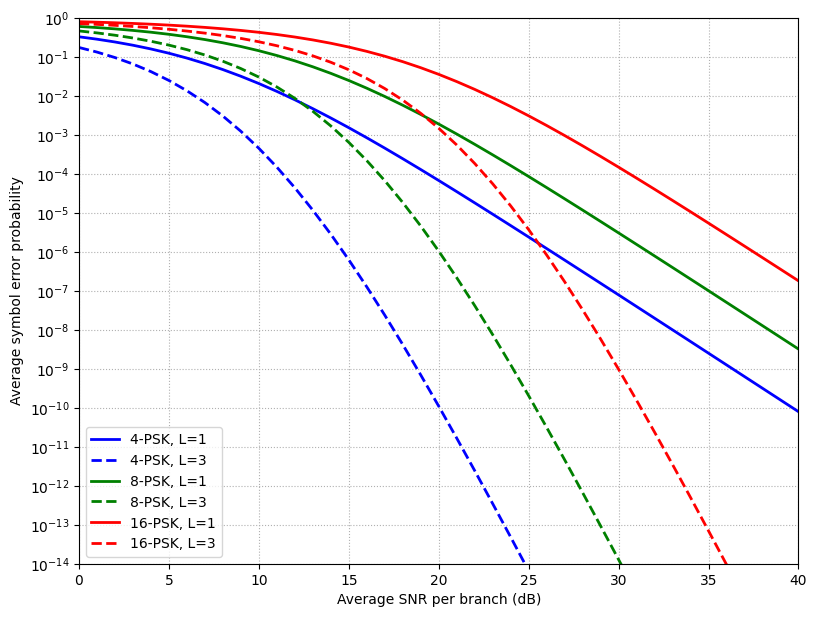

In [ ]:
import matplotlib.pyplot as plt

# Parâmetros de simulação M-PSK

eta = 2                                 # Razão de potências quadratura/em fase
mu = 1.5                                # Número de clusters multipath
delta = 0.5                             # Fator de decaimento de potência entre ramos
snr_db = np.arange(0, 41, 1)            # SNR médio por ramo, em dB

plt.figure(figsize=(8,6))

# M=4, L=1
Pe_4_1 = asep_mpsk(snr_db, 4, 1, mu, eta, delta)
plt.semilogy(snr_db, Pe_4_1, '-', color='b', linewidth=2, label='4-PSK, L=1')

# M=4, L=3
Pe_4_3 = asep_mpsk(snr_db, 4, 3, mu, eta, delta)
plt.semilogy(snr_db, Pe_4_3, '--', color='b', linewidth=2, label='4-PSK, L=3')

# M=8, L=1
Pe_8_1 = asep_mpsk(snr_db, 8, 1, mu, eta, delta)
plt.semilogy(snr_db, Pe_8_1, '-', color='g', linewidth=2, label='8-PSK, L=1')

# M=4, L=3
Pe_8_3 = asep_mpsk(snr_db, 8, 3, mu, eta, delta)
plt.semilogy(snr_db, Pe_8_3, '--', color='g', linewidth=2, label='8-PSK, L=3')

# M=16, L=1
Pe_16_1 = asep_mpsk(snr_db, 16, 1, mu, eta, delta)
plt.semilogy(snr_db, Pe_16_1, '-', color='r', linewidth=2, label='16-PSK, L=1')

# M=16, L=3
Pe_16_3 = asep_mpsk(snr_db, 16, 3, mu, eta, delta)
plt.semilogy(snr_db, Pe_16_3, '--', color='r', linewidth=2, label='16-PSK, L=3')

plt.xlabel('Average SNR per branch (dB)')
plt.ylabel('Average symbol error probability')
plt.grid(True, which='both', linestyle=':')
plt.ylim(1e-14, 1)
plt.xlim(0, 40)
yticks = [1e0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13, 1e-14]
ylabels = [r'$10^{0}$', r'$10^{-1}$', r'$10^{-2}$', r'$10^{-3}$', r'$10^{-4}$', r'$10^{-5}$', r'$10^{-6}$', r'$10^{-7}$', r'$10^{-8}$', r'$10^{-9}$', r'$10^{-10}$', r'$10^{-11}$', r'$10^{-12}$', r'$10^{-13}$', r'$10^{-14}$']
plt.yticks(yticks, ylabels)
plt.legend(loc='lower left')
plt.tight_layout(pad=0.1)
plt.show()


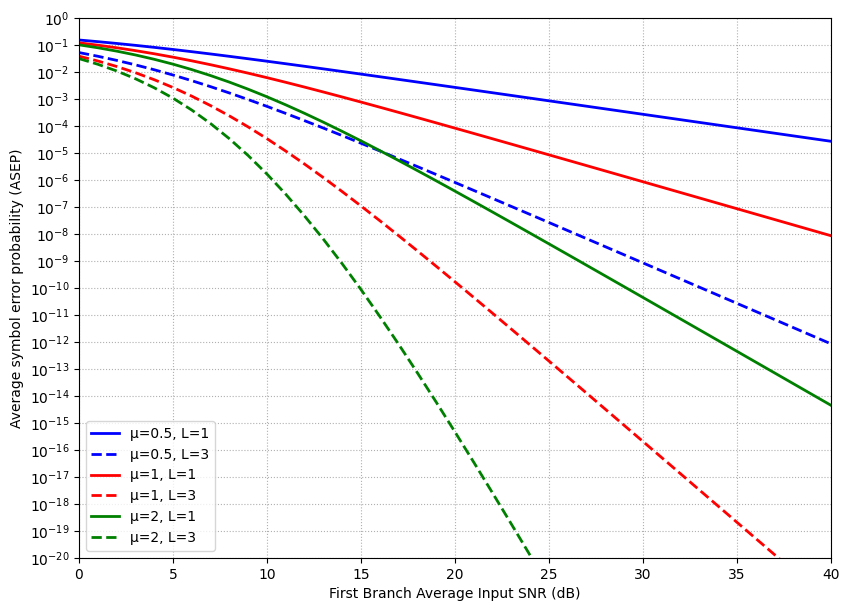

In [ ]:
# Parâmetros de simulação BPSK
eta = 2                          # Razão de potências quadratura/em fase
mu_values = [0.5, 1, 2]          # Número de clusters multipath
L_values = [1, 3]                # Números de ramos de diversidade MRC
delta = 0.5                      # Fator de decaimento de potência entre ramos

snr_db = np.linspace(0, 40, 41)  # SNR médio por ramo (em dB)
snr_lin = 10**(snr_db/10)        # SNR em escala linear

plt.figure(figsize=(8,6))

# mu = 0.5, L = 1
Pe_05_1 = asep_mpsk(snr_db, 2,  1, 0.5, eta, delta)
plt.semilogy(snr_db, Pe_05_1, '-', color='b', linewidth=2, label='μ=0.5, L=1')

# mu = 0.5, L = 3
Pe_05_3 = asep_mpsk(snr_db, 2, 3, 0.5, eta, delta)
plt.semilogy(snr_db, Pe_05_3, '--', color='b', linewidth=2, label='μ=0.5, L=3')

# mu = 1, L = 1
Pe_1_1 = asep_mpsk(snr_db, 2, 1, 1, eta, delta)
plt.semilogy(snr_db, Pe_1_1, '-', color='r', linewidth=2, label='μ=1, L=1')

# mu = 1, L = 3
Pe_1_3 = asep_mpsk(snr_db, 2, 3, 1, eta, delta)
plt.semilogy(snr_db, Pe_1_3, '--', color='r', linewidth=2, label='μ=1, L=3')

# mu = 2, L = 1
Pe_2_1 = asep_mpsk(snr_db, 2, 1, 2, eta, delta)
plt.semilogy(snr_db, Pe_2_1, '-', color='g', linewidth=2, label='μ=2, L=1')

# mu = 2, L = 3
Pe_2_3 = asep_mpsk(snr_db, 2, 3, 2, eta, delta)
plt.semilogy(snr_db, Pe_2_3, '--', color='g', linewidth=2, label='μ=2, L=3')

plt.xlabel('First Branch Average Input SNR (dB)')
plt.ylabel('Average symbol error probability (ASEP)')
plt.grid(True, which='both', linestyle=':')
plt.ylim(1e-20, 1)
plt.xlim(0, 40)
yticks = [1e0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13, 1e-14, 1e-15, 1e-16, 1e-17, 1e-18, 1e-19, 1e-20]
ylabels = [r'$10^{0}$', r'$10^{-1}$', r'$10^{-2}$', r'$10^{-3}$', r'$10^{-4}$', r'$10^{-5}$', r'$10^{-6}$', r'$10^{-7}$', r'$10^{-8}$', r'$10^{-9}$', r'$10^{-10}$', r'$10^{-11}$', r'$10^{-12}$', r'$10^{-13}$', r'$10^{-14}$', r'$10^{-15}$', r'$10^{-16}$', r'$10^{-17}$', r'$10^{-18}$', r'$10^{-19}$', r'$10^{-20}$']
plt.yticks(yticks, ylabels)
plt.legend(loc='lower left')
plt.tight_layout(pad=0.1)
plt.subplots_adjust(left=0.04, right=0.98, top=0.98, bottom=0.08)
plt.show()

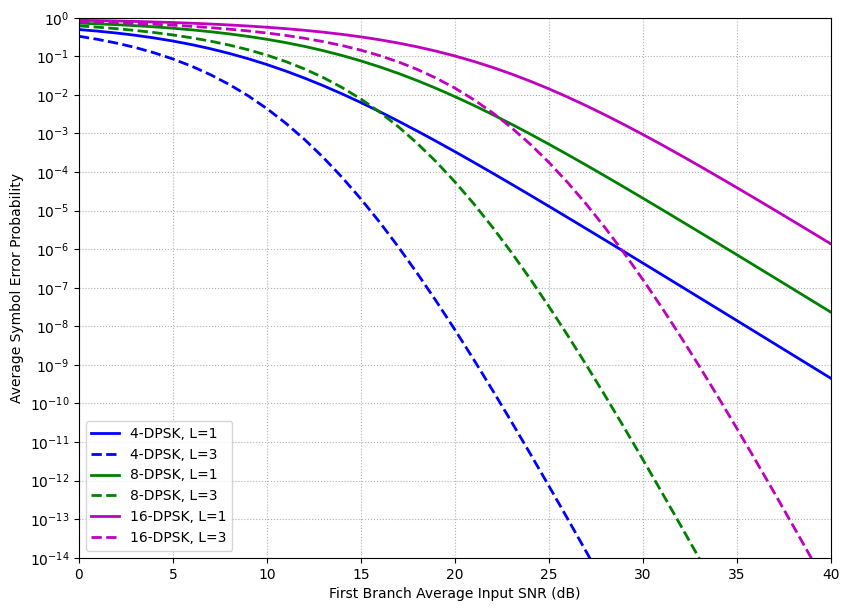

In [ ]:
# Parâmetros de simulação M-DPSK
eta = 2                           # Razão de potências quadratura/em fase
mu = 1.5                          # Número de clusters multipath
delta = 0.5                       # Fator de decaimento de potência entre ramos
snr_db = np.linspace(0, 40, 41)   # SNR médio por ramo (em dB)

plt.figure(figsize=(8,6))

# M = 4, L = 1
Pe_4_1 = asep_mdpsk(snr_db, 4, 1, mu, eta, delta)
plt.semilogy(snr_db, Pe_4_1, '-', color='b', linewidth=2, label='4-DPSK, L=1')

# M = 4, L = 3
Pe_4_3 = asep_mdpsk(snr_db, 4, 3, mu, eta, delta)
plt.semilogy(snr_db, Pe_4_3, '--', color='b', linewidth=2, label='4-DPSK, L=3')

# M = 8, L = 1
Pe_8_1 = asep_mdpsk(snr_db, 8, 1, mu, eta, delta)
plt.semilogy(snr_db, Pe_8_1, '-', color='g', linewidth=2, label='8-DPSK, L=1')

# M = 8, L = 3
Pe_8_3 = asep_mdpsk(snr_db, 8, 3, mu, eta, delta)
plt.semilogy(snr_db, Pe_8_3, '--', color='g', linewidth=2, label='8-DPSK, L=3')

# M = 16, L = 1
Pe_16_1 = asep_mdpsk(snr_db, 16, 1, mu, eta, delta)
plt.semilogy(snr_db, Pe_16_1, '-', color='m', linewidth=2, label='16-DPSK, L=1')

# M = 16, L = 3
Pe_16_3 = asep_mdpsk(snr_db, 16, 3, mu, eta, delta)
plt.semilogy(snr_db, Pe_16_3, '--', color='m', linewidth=2, label='16-DPSK, L=3')

plt.xlabel('First Branch Average Input SNR (dB)')
plt.ylabel('Average Symbol Error Probability')
plt.grid(True, which='both', linestyle=':')
plt.ylim(1e-14, 1)
plt.xlim(0, 40)
yticks = [1e0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13, 1e-14]
ylabels = [r'$10^{0}$', r'$10^{-1}$', r'$10^{-2}$', r'$10^{-3}$', r'$10^{-4}$', r'$10^{-5}$', r'$10^{-6}$', r'$10^{-7}$', r'$10^{-8}$', r'$10^{-9}$', r'$10^{-10}$', r'$10^{-11}$', r'$10^{-12}$', r'$10^{-13}$', r'$10^{-14}$']
plt.yticks(yticks, ylabels)
plt.legend(loc='lower left')
plt.tight_layout(pad=0.1)
plt.subplots_adjust(left=0.04, right=0.98, top=0.98, bottom=0.08)
plt.show()

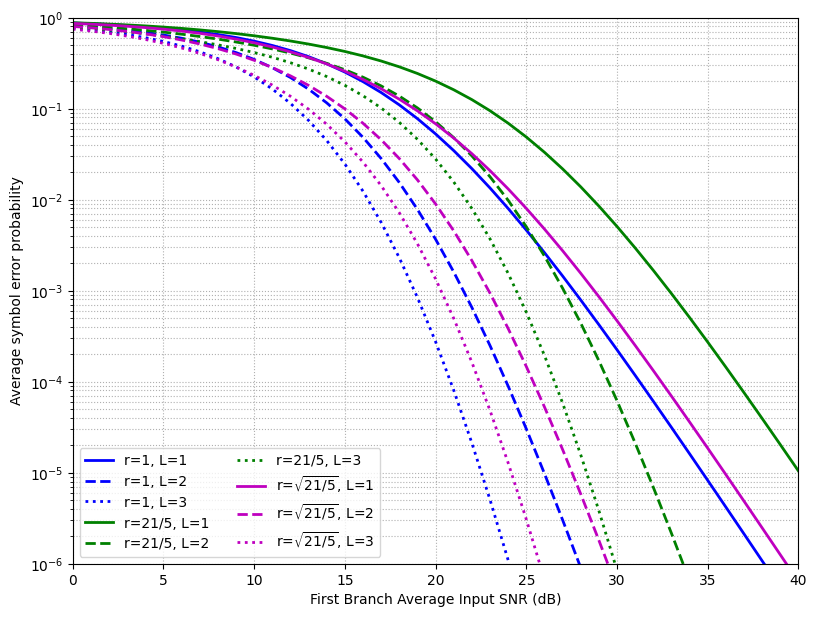

In [ ]:

# Parâmetros de simulação 8x4 QAM
eta = 2                           # Razão de potências quadratura/em fase
mu = 1.5                          # Número de clusters multipath
delta = 0                         # Fator de decaimento de potência entre ramos
L_values = [1, 2, 3]
r_values = [1, 21/5, (21/5)**0.5]
MI = 8                            # Níveis de modulação no eixo I
MQ = 4                            # Níveis de modulação no eixo Q
snr_db = np.linspace(0, 40, 41)   # SNR médio por ramo (em dB)


plt.figure(figsize=(8,6))

Pe_r1_L1 = asep_qam(snr_db, MI, MQ, r_values[0], 1, mu, eta, delta)
plt.semilogy(snr_db, Pe_r1_L1, '-', color='b', linewidth=2, label='r=1, L=1')

Pe_r1_L2 = asep_qam(snr_db, MI, MQ, r_values[0], 2, mu, eta, delta)
plt.semilogy(snr_db, Pe_r1_L2, '--', color='b', linewidth=2, label='r=1, L=2')

Pe_r1_L3 = asep_qam(snr_db, MI, MQ, r_values[0], 3, mu, eta, delta)
plt.semilogy(snr_db, Pe_r1_L3, ':', color='b', linewidth=2, label='r=1, L=3')

Pe_r2_L1 = asep_qam(snr_db, MI, MQ, r_values[1], 1, mu, eta, delta)
plt.semilogy(snr_db, Pe_r2_L1, '-', color='g', linewidth=2, label='r=21/5, L=1')

Pe_r2_L2 = asep_qam(snr_db, MI, MQ, r_values[1], 2, mu, eta, delta)
plt.semilogy(snr_db, Pe_r2_L2, '--', color='g', linewidth=2, label='r=21/5, L=2')

Pe_r2_L3 = asep_qam(snr_db, MI, MQ, r_values[1], 3, mu, eta, delta)
plt.semilogy(snr_db, Pe_r2_L3, ':', color='g', linewidth=2, label='r=21/5, L=3')

Pe_r3_L1 = asep_qam(snr_db, MI, MQ, r_values[2], 1, mu, eta, delta)
plt.semilogy(snr_db, Pe_r3_L1, '-', color='m', linewidth=2, label='r=$\sqrt{21/5}$, L=1')

Pe_r3_L2 = asep_qam(snr_db, MI, MQ, r_values[2], 2, mu, eta, delta)
plt.semilogy(snr_db, Pe_r3_L2, '--', color='m', linewidth=2, label='r=$\sqrt{21/5}$, L=2')

Pe_r3_L3 = asep_qam(snr_db, MI, MQ, r_values[2], 3, mu, eta, delta)
plt.semilogy(snr_db, Pe_r3_L3, ':', color='m', linewidth=2, label='r=$\sqrt{21/5}$, L=3')

plt.xlabel('First Branch Average Input SNR (dB)')
plt.ylabel('Average symbol error probability')
plt.grid(True, which='both', linestyle=':')
plt.ylim(1e-6, 1)
plt.xlim(0, 40)
plt.legend(loc='lower left', ncol=2)
plt.tight_layout(pad=0.1)
plt.show()
